# Names Transition Modeling

In [1]:
import pandas as pd 
import unicodedata 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import re 
import sys 
import os 

sys.path.append(os.path.abspath("..")) 
from collections import Counter 
from core.utils.data_loader import DataLoader 
from core.config.pipeline_config import PipelineConfig

In [2]:
config = PipelineConfig(
    paths={
        "root_dir": "../data",
        "data_dir": "../data/dataset",
        "models_dir": "../models",
        "outputs_dir": "../data/processed",
        "logs_dir": "../logs",
        "configs_dir": "../configs",
        "checkpoints_dir": "../checkpoints"
    }
)

loader = DataLoader(config)

def normalize_letters(s):
    """Normalize accents -> ascii, lowercase, keep only a-z."""
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = s.encode("ascii", errors="ignore").decode("utf-8")
    s = s.lower()
    s = re.sub(r"[^a-z]", "", s)
    return s

In [3]:
df = loader.load_csv_complete(config.paths.data_dir / "names_featured.csv")

def clean_province(s):
    return (
        s.str.upper()
        .str.strip()
        .apply(lambda x: unicodedata.normalize("NFKD", x)
               .encode("ascii", errors="ignore")
               .decode("utf-8") if isinstance(x, str) else x)
    )
df['province'] = clean_province(df['province'])

df_simple = df[df['identified_category'] == 'simple'].copy()
df_simple['surname'] = df_simple['identified_name'].str.split().str[0]
df_simple['middle_name'] = df_simple['identified_name'].str.split().str[1]
df_simple['first_name'] = df_simple['identified_surname']
df_simple = df_simple[df_simple['first_name'].notna() & (df_simple['first_name'].str.strip() != '')]

In [4]:
display(df['province'].value_counts().reset_index().head(12))

,province,count
0,KINSHASA,1140620
1,AUTRES,1035751
2,KATANGA,836220
3,BANDUNDU,809949
4,KASAI-ORIENTAL,434497
5,NORD-KIVU,394999
6,KASAI-OCCIDENTAL,367626
7,EQUATEUR,356404
8,SUD-KIVU,346152
9,ORIENTALE,322756


# Surname (for whole country)

In [5]:
surnames = df_simple['surname'].astype(str).str.lower().tolist()
surnames = [re.sub(r"[^a-z]", "", name) for name in surnames] 
sequences = ['^' + s + '$' for s in surnames if s]

tokens = ['^'] + list('abcdefghijklmnopqrstuvwxyz') + ['$']
index = {t: i for i, t in enumerate(tokens)}

In [6]:
transitions = Counter()
for seq in sequences:
    for a, b in zip(seq, seq[1:]):
        if a in index and b in index:
            transitions[(a, b)] += 1

matrix = np.zeros((len(tokens), len(tokens)), dtype=int)
for (a, b), count in transitions.items():
    matrix[index[a], index[b]] += count

df_counts = pd.DataFrame(matrix, index=tokens, columns=tokens)
df_probs = df_counts.div(df_counts.sum(axis=1).replace(0, 1), axis=0)    

## Transition matrix for the entire country

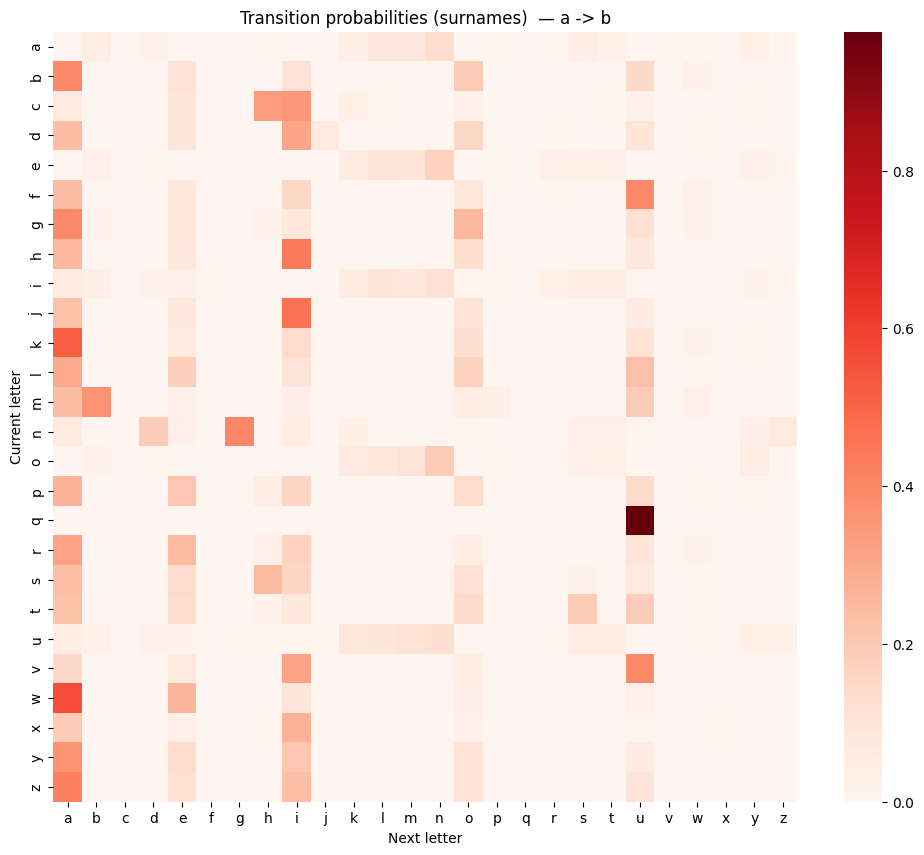

In [7]:
letters = list('abcdefghijklmnopqrstuvwxyz')
plt.figure(figsize=(12, 10))
sns.heatmap(df_probs.loc[letters, letters].values,
            xticklabels=letters, yticklabels=letters,
            cmap="Reds")
plt.title("Transition probabilities (surnames)  — a -> b")
plt.xlabel("Next letter")
plt.ylabel("Current letter")
plt.show()

In [8]:
all_letters = "".join(df_simple['surname'].astype(str).str.lower().tolist())
letters_only = [c for c in all_letters if c.isalpha()]

counts = Counter(letters_only)
letters = list("abcdefghijklmnopqrstuvwxyz")

# Build DataFrame with all 26 letters
df_letters = pd.DataFrame({
    "letter": letters,
    "count": [counts.get(l, 0) for l in letters]
})

# Compute relative frequencies
df_letters["freq"] = df_letters["count"] / df_letters["count"].sum()
df_letters

,letter,count,freq
0,a,5638609,0.175533
1,b,1982642,0.061721
2,c,67967,0.002116
3,d,833422,0.025945
4,e,1888919,0.058803
5,f,161048,0.005014
6,g,1189924,0.037043
7,h,502652,0.015648
8,i,2434995,0.075803
9,j,137482,0.004280


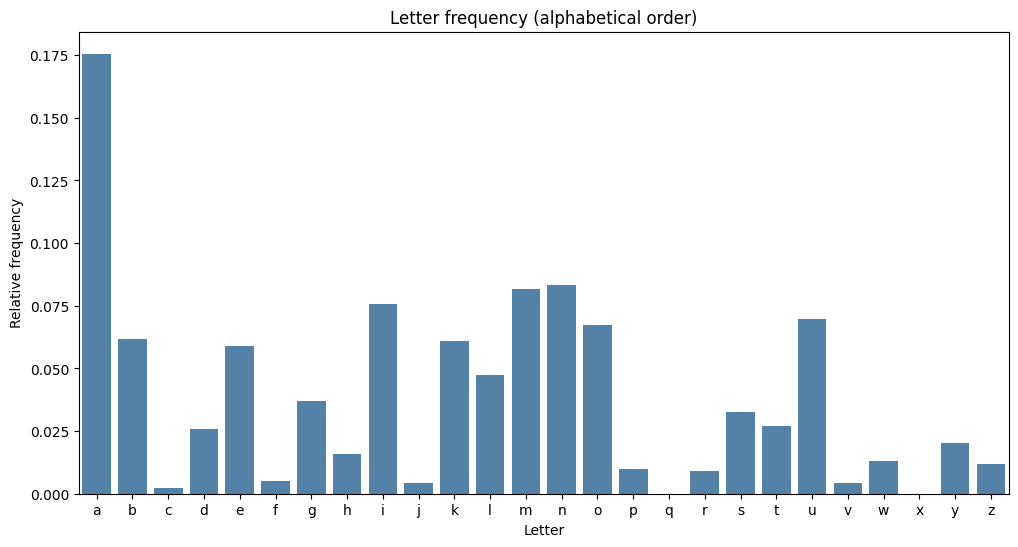

In [9]:
plt.figure(figsize=(12,6))
sns.barplot(x="letter", y="freq", data=df_letters, color="steelblue")
plt.title("Letter frequency (alphabetical order)")
plt.xlabel("Letter")
plt.ylabel("Relative frequency")
plt.show()

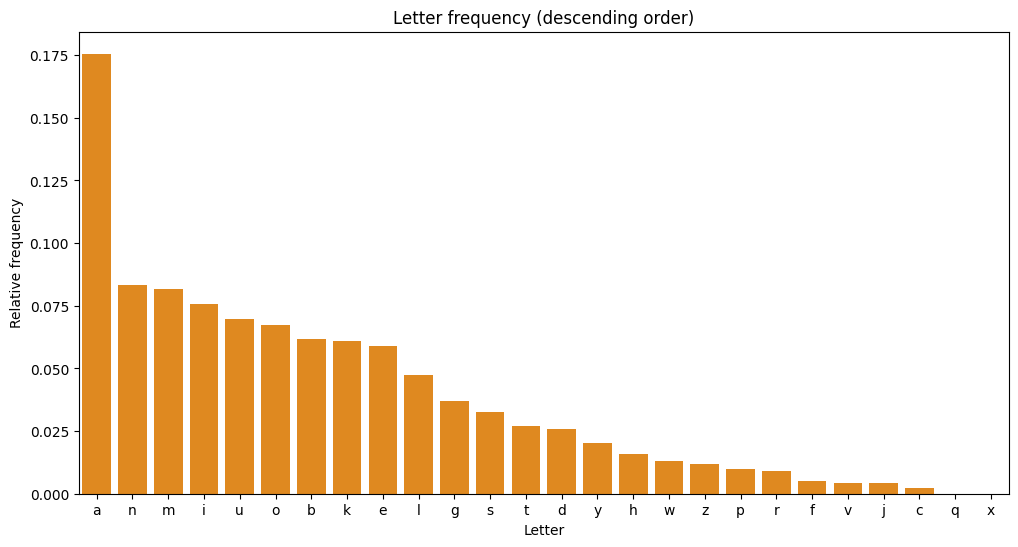

In [10]:
df_sorted = df_letters.sort_values("freq", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="letter", y="freq", data=df_sorted, color="darkorange")
plt.title("Letter frequency (descending order)")
plt.xlabel("Letter")
plt.ylabel("Relative frequency")
plt.show()

In [11]:
df_letters.sort_values("freq", ascending=False).reset_index(drop=True).head(20)

,letter,count,freq
0,a,5638609,0.175533
1,n,2675387,0.083286
2,m,2625688,0.081739
3,i,2434995,0.075803
4,u,2235199,0.069583
5,o,2159415,0.067224
6,b,1982642,0.061721
7,k,1951774,0.060760
8,e,1888919,0.058803
9,l,1520935,0.047348


## Fréquence des bigrammes et trigrammes les plus utilisés

In [12]:
letters = list("abcdefghijklmnopqrstuvwxyz")
index = {l: i for i, l in enumerate(letters)}
matrix = np.zeros((26, 26), dtype=int)

for name in df_simple['surname'].astype(str).str.lower():
    name = re.sub(r"[^a-z]", "", name)
    for a, b in zip(name, name[1:]):
        if a in index and b in index:
            matrix[index[a], index[b]] += 1

df_bigrams_matrix = pd.DataFrame(matrix, index=letters, columns=letters)

### Fréquence des bigrammes

In [13]:
letters = list("abcdefghijklmnopqrstuvwxyz")
index = {l: i for i, l in enumerate(letters)}
matrix = np.zeros((26, 26), dtype=int)

for name in df_simple['surname'].astype(str).str.lower():
    name = re.sub(r"[^a-z]", "", name)
    for a, b in zip(name, name[1:]):
        if a in index and b in index:
            matrix[index[a], index[b]] += 1

df_bigrams_matrix = pd.DataFrame(matrix, index=letters, columns=letters)

### Heatmap des bigrammes

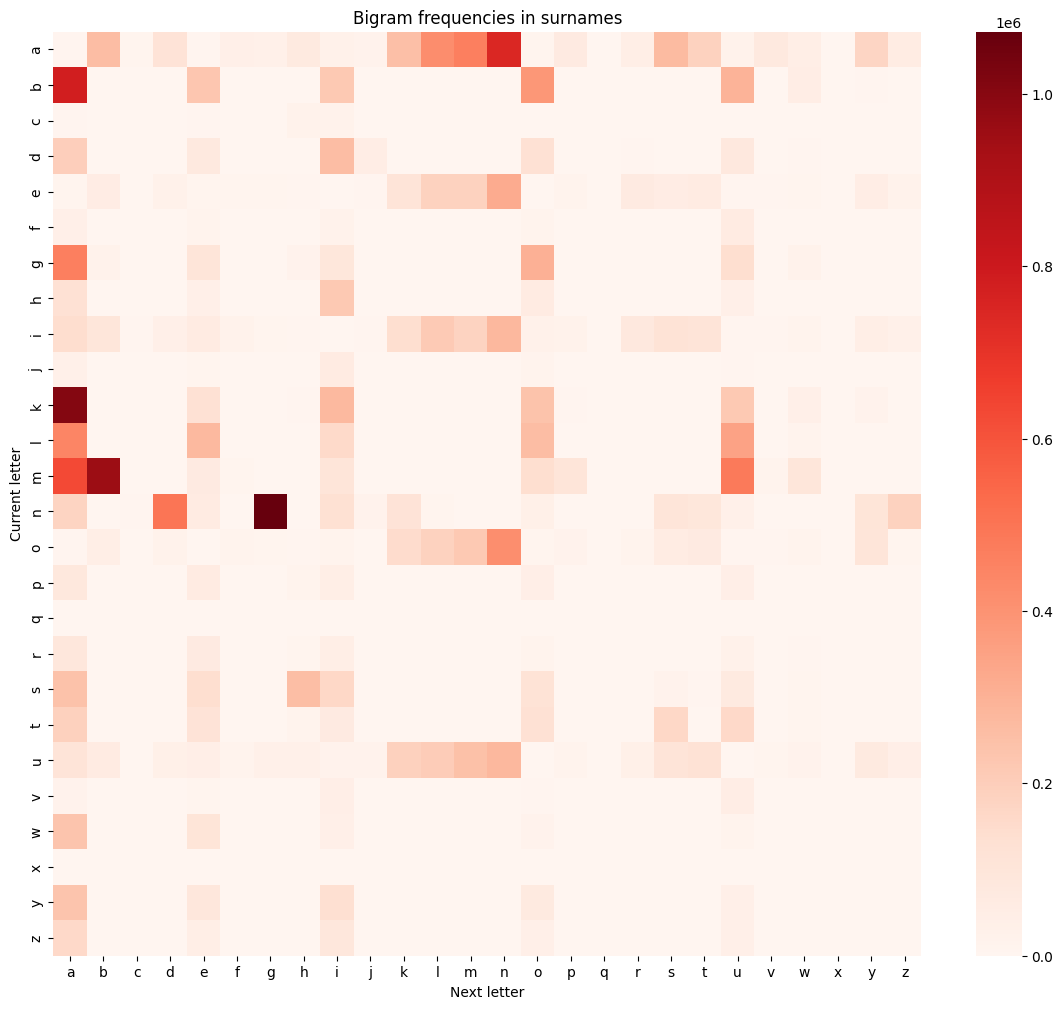

In [14]:
plt.figure(figsize=(14, 12))
sns.heatmap(df_bigrams_matrix, cmap="Reds", cbar=True, xticklabels=letters, yticklabels=letters)
plt.title("Bigram frequencies in surnames")
plt.xlabel("Next letter")
plt.ylabel("Current letter")
plt.show()

### Tableau des bigrammes

In [15]:
df_bigrams_matrix.head(26)  

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
a,5228,263129,8991,116767,6306,38087,30182,75189,28541,19495,...,28,48719,268202,186897,24085,75440,47762,40,173351,60875
b,781156,166,0,1186,226715,1,93,2932,221388,9,...,1,2049,23,16,293343,16,51227,1,8320,18
c,4411,1,280,0,6411,0,6,23056,23602,2,...,458,185,6,579,1700,0,323,0,545,2
d,199445,13,0,429,76782,8,17,3760,259819,54307,...,0,6879,66,14,79705,19,6706,1,2546,1787
e,10218,55430,1806,28464,9164,9016,8840,6778,2636,6489,...,9,70449,57711,65537,4229,4548,10063,318,54429,23871
f,38611,0,0,4,13782,198,3,22,24087,0,...,1,1345,45,79,63527,0,4005,0,798,1
g,466541,24772,9,44,102163,7,38,18597,94315,13,...,2,1169,25,15,141016,4,23274,0,1630,8
h,126923,20,2,11,38849,16,9,8,221195,9,...,1,900,96,82,40774,4,1921,0,1048,4
i,142956,99789,5475,40211,65119,22757,11706,8267,955,6000,...,614,79659,120640,112233,5614,7655,14137,135,46205,32395
j,31283,2,5,30,11267,1,2,17,63052,13,...,0,6,1,11,8367,2,257,0,37,1


In [16]:
# Counting bigrams
bigram_counter = Counter()
for name in surnames:
    for a, b in zip(name, name[1:]):
        bigram_counter[a+b] += 1

top_bigrams = bigram_counter.most_common(10)

# Counting trigrams
trigram_counter = Counter()
for name in surnames:
    for a, b, c in zip(name, name[1:], name[2:]):
        trigram_counter[a+b+c] += 1

top_trigrams = trigram_counter.most_common(10)

### The most frequently used bigrams

In [17]:
df_bigrams = pd.DataFrame(bigram_counter.most_common(10), columns=["bigram", "count"])
display(df_bigrams)

,bigram,count
0,ng,1072187
1,ka,1007696
2,mb,957543
3,ba,781156
4,an,746783
5,ma,630378
6,nd,501221
7,mu,485738
8,ga,466541
9,am,466334


### The most commonly used trigrams

In [18]:
df_trigrams = pd.DataFrame(trigram_counter.most_common(10), columns=["trigram", "count"])
display(df_trigrams)

,trigram,count
0,nga,438962
1,mba,400099
2,ngo,289073
3,amb,269415
4,ang,266051
5,ong,215334
6,nda,176952
7,mbo,176921
8,ala,175773
9,shi,161218


## Name generation

In [19]:
tokens = ["^"] + list("abcdefghijklmnopqrstuvwxyz") + ["$"]
index = {t: i for i, t in enumerate(tokens)}

def generate_name(prob_matrix, index, tokens, max_len=12):
    current = '^'
    result = []
    
    for _ in range(max_len):
        row = prob_matrix[index[current]]
        next_letter = np.random.choice(tokens, p=row)
        
        if next_letter == '$':
            break
        
        result.append(next_letter)
        current = next_letter
    
    return "".join(result).capitalize()

generated_names = [generate_name(df_probs.values, index, tokens) for _ in range(10)]
generated_names

['Kananyikyumb',
 'A',
 'Nka',
 'Kayomayi',
 'Ngo',
 'Ka',
 'Bondimema',
 'Nzongonzimba',
 'Ndibon',
 'Muama']